In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [2]:
# Load preprocessed dataset
df = pd.read_csv(r"E:\jupyter-codes\ML_Gatech\CS_7641_Project-main\CS_7641_Project-main\Qualifying_Lap_Predictor\data_collection\Combined_Quali_FP2_data\qualifying_with_fp2_features_standardized_teams.csv")

# Drop inaccurate laps
df = df[df["IsAccurate"] == True].copy()

In [5]:
df

,Year,Round,GrandPrix,CircuitName,CircuitType,Location,Country,Driver,Team,LapTime_seconds,...,TrackStatus,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,WindSpeed,WindDirection,FP2_LapTime,FP2_GapToBest
0,2022,1,Bahrain Grand Prix,Bahrain Grand Prix,permanent,Sakhir,Bahrain,ALB,Williams,92.664,...,1.0,True,19.7,57,1013.7,False,0.5,74,94.735,2.799
1,2022,1,Bahrain Grand Prix,Bahrain Grand Prix,permanent,Sakhir,Bahrain,ALO,Alpine,91.621,...,1.0,True,19.7,57,1013.7,False,0.5,74,92.877,0.941
2,2022,1,Bahrain Grand Prix,Bahrain Grand Prix,permanent,Sakhir,Bahrain,BOT,Kick Sauber,91.560,...,1.0,True,19.7,57,1013.7,False,0.5,74,92.951,1.015
3,2022,1,Bahrain Grand Prix,Bahrain Grand Prix,permanent,Sakhir,Bahrain,GAS,RB,91.635,...,1.0,True,19.7,57,1013.7,False,0.5,74,93.621,1.685
4,2022,1,Bahrain Grand Prix,Bahrain Grand Prix,permanent,Sakhir,Bahrain,HAM,Mercedes,91.048,...,1.0,True,19.7,57,1013.7,False,0.5,74,93.144,1.208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,2025,10,Canadian Grand Prix,Canadian Grand Prix,permanent,Montréal,Canada,RUS,Mercedes,70.899,...,1.0,True,21.2,29,1019.0,False,3.1,356,72.123,0.000
1453,2025,10,Canadian Grand Prix,Canadian Grand Prix,permanent,Montréal,Canada,SAI,Williams,72.398,...,1.0,True,21.2,29,1019.0,False,3.1,356,72.631,0.508
1454,2025,10,Canadian Grand Prix,Canadian Grand Prix,permanent,Montréal,Canada,STR,Aston Martin,72.517,...,1.0,True,21.2,29,1019.0,False,3.1,356,NaN,NaN
1455,2025,10,Canadian Grand Prix,Canadian Grand Prix,permanent,Montréal,Canada,TSU,Red Bull,72.102,...,1.0,True,21.2,29,1019.0,False,3.1,356,72.939,0.816


In [43]:
# Target
y = df["LapTime_seconds"]

In [44]:
# Features

categorical_cols = ["Driver", "Team", "Tyre", "CircuitType","FreshTyre", "GrandPrix"]   #adding fresh tyre feature 
numeric_cols = [
    "Year", "Round", "AirTemp", "Humidity", "Pressure", "Rainfall",
    "WindSpeed", "WindDirection", "TyreLife", "Sector1Time","Sector2Time", "FP2_LapTime", "FP2_GapToBest"
]

#numeric_cols = [
#    "Year", "Round", "AirTemp", "Humidity", "Pressure", "Rainfall",
#    "WindSpeed", "WindDirection", "TyreLife", "Sector1Time", "Sector2Time", "Sector3Time", "FP2_LapTime", "FP2_GapToBest"
#]

In [45]:
X = df[categorical_cols + numeric_cols]

In [46]:
# Preprocessing
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_cols),
    ("num", num_pipeline, numeric_cols)
])


In [47]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
# Define models and parameter grids
model_configs = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}  
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {"regressor__alpha": [0.01, 0.1, 1.0, 10.0]}
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [50, 100],
            "regressor__max_depth": [None, 10, 20]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [50, 100],
            "regressor__learning_rate": [0.05, 0.1],
            "regressor__max_depth": [3, 5]
        }
    }
}

In [49]:
# Training loop with GridSearchCV
results = {}

for name, cfg in model_configs.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", cfg["model"])
    ])

    grid = GridSearchCV(pipe, cfg["params"], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Best Params": grid.best_params_
    }

In [63]:
results

{'Linear Regression': {'MAE': 0.7210171536101588,
  'RMSE': 1.325666720869264,
  'R2': 0.9869623005474153,
  'Best Params': {}},
 'Ridge Regression': {'MAE': 0.6729959167471676,
  'RMSE': 1.1896373887920142,
  'R2': 0.9895006728676957,
  'Best Params': {'regressor__alpha': 0.1}},
 'Random Forest': {'MAE': 0.47373182027649813,
  'RMSE': 1.3600857496642913,
  'R2': 0.9862765015389529,
  'Best Params': {'regressor__max_depth': None,
   'regressor__n_estimators': 100}},
 'Gradient Boosting': {'MAE': 0.49477588732085903,
  'RMSE': 1.2399523769159595,
  'R2': 0.988593766228257,
  'Best Params': {'regressor__learning_rate': 0.1,
   'regressor__max_depth': 5,
   'regressor__n_estimators': 100}}}

In [50]:
# Results
results_df = pd.DataFrame(results).T.sort_values("RMSE")
print("\nModel Evaluation Metrics (Grid Search):\n")
print(results_df)


Model Evaluation Metrics (Grid Search):

                        MAE      RMSE        R2  \
Ridge Regression   0.672996  1.189637  0.989501   
Gradient Boosting  0.494776  1.239952  0.988594   
Linear Regression  0.721017  1.325667  0.986962   
Random Forest      0.473732  1.360086  0.986277   

                                                         Best Params  
Ridge Regression                           {'regressor__alpha': 0.1}  
Gradient Boosting  {'regressor__learning_rate': 0.1, 'regressor__...  
Linear Regression                                                 {}  
Random Forest      {'regressor__max_depth': None, 'regressor__n_e...  


In [51]:
results_df

,MAE,RMSE,R2,Best Params
Ridge Regression,0.672996,1.189637,0.989501,{'regressor__alpha': 0.1}
Gradient Boosting,0.494776,1.239952,0.988594,"{'regressor__learning_rate': 0.1, 'regressor__..."
Linear Regression,0.721017,1.325667,0.986962,{}
Random Forest,0.473732,1.360086,0.986277,"{'regressor__max_depth': None, 'regressor__n_e..."


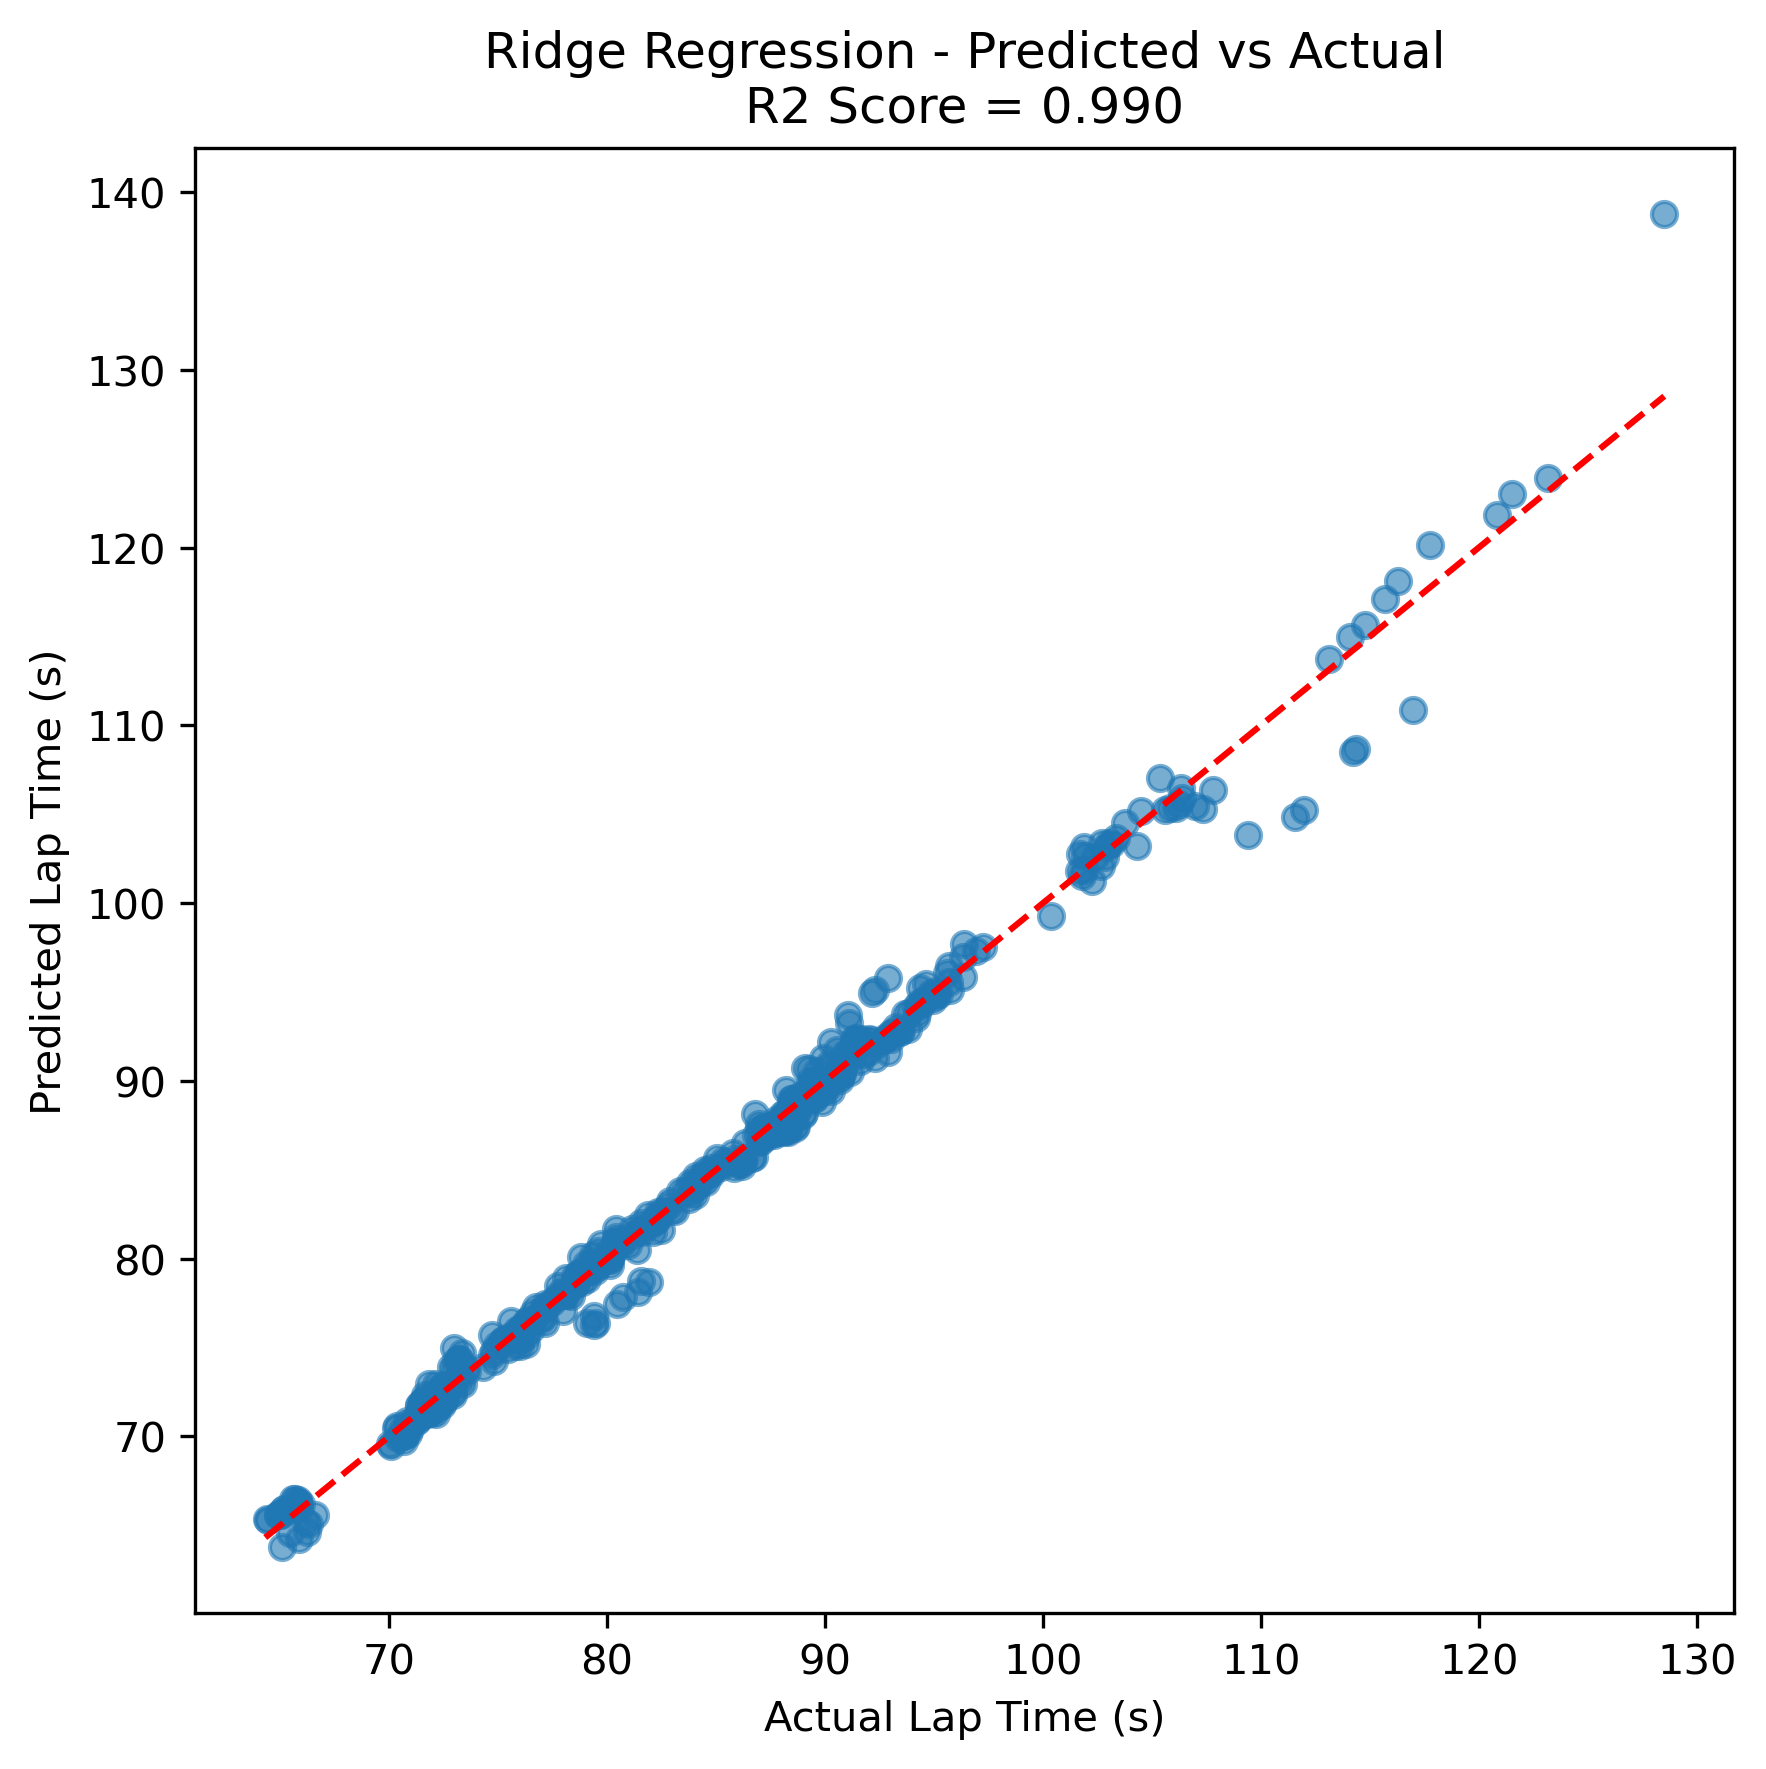

In [53]:
# Plot predicted vs actual for best model
best_model_name = results_df.index[0]
best_model_pipe = model_configs[best_model_name]["model"]
best_grid = GridSearchCV(
    Pipeline([("preprocessor", preprocessor), ("regressor", best_model_pipe)]),
    model_configs[best_model_name]["params"],
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
best_grid.fit(X_train, y_train)
best_estimator = best_grid.best_estimator_
y_pred = best_estimator.predict(X_test)
r2_final = r2_score(y_test, y_pred)

plt.figure(figsize=(6, 6),dpi=300)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title(f"{best_model_name} - Predicted vs Actual\nR2 Score = {r2_final:.3f}")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.tight_layout()
plt.show()

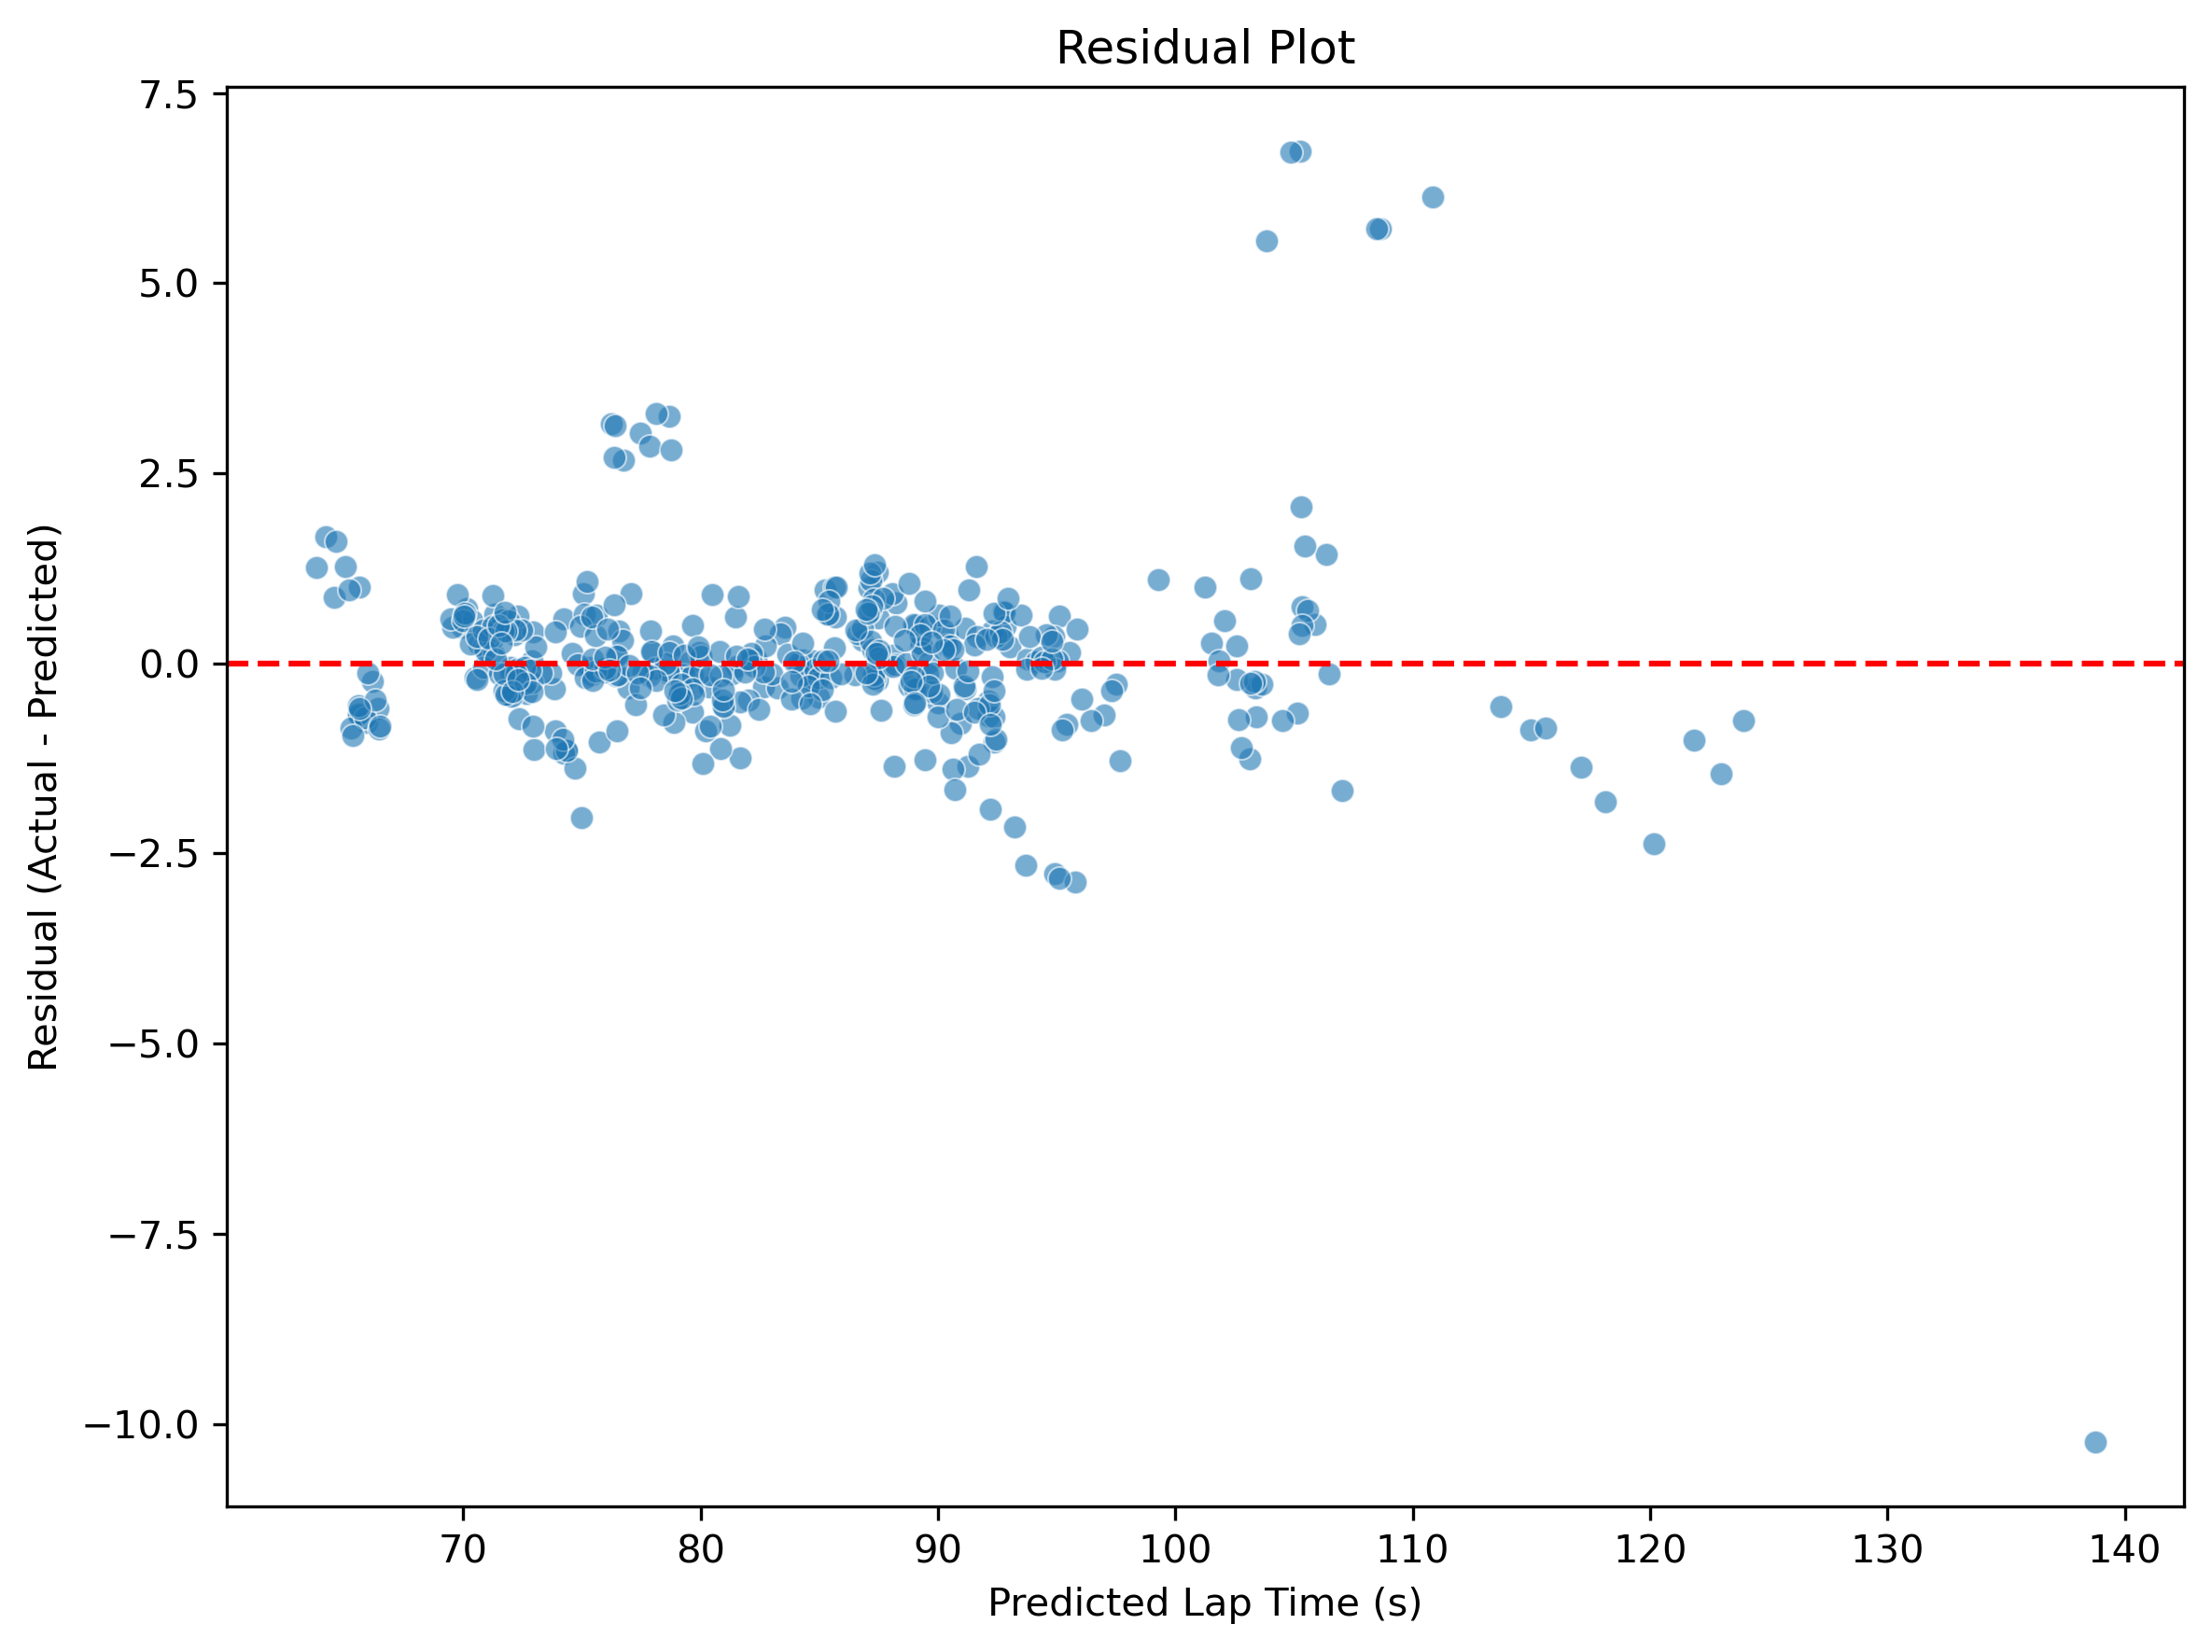

In [54]:
#Residual Plot
y_test_pred = best_estimator.predict(X_test)
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6), dpi=300)
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Lap Time (s)")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


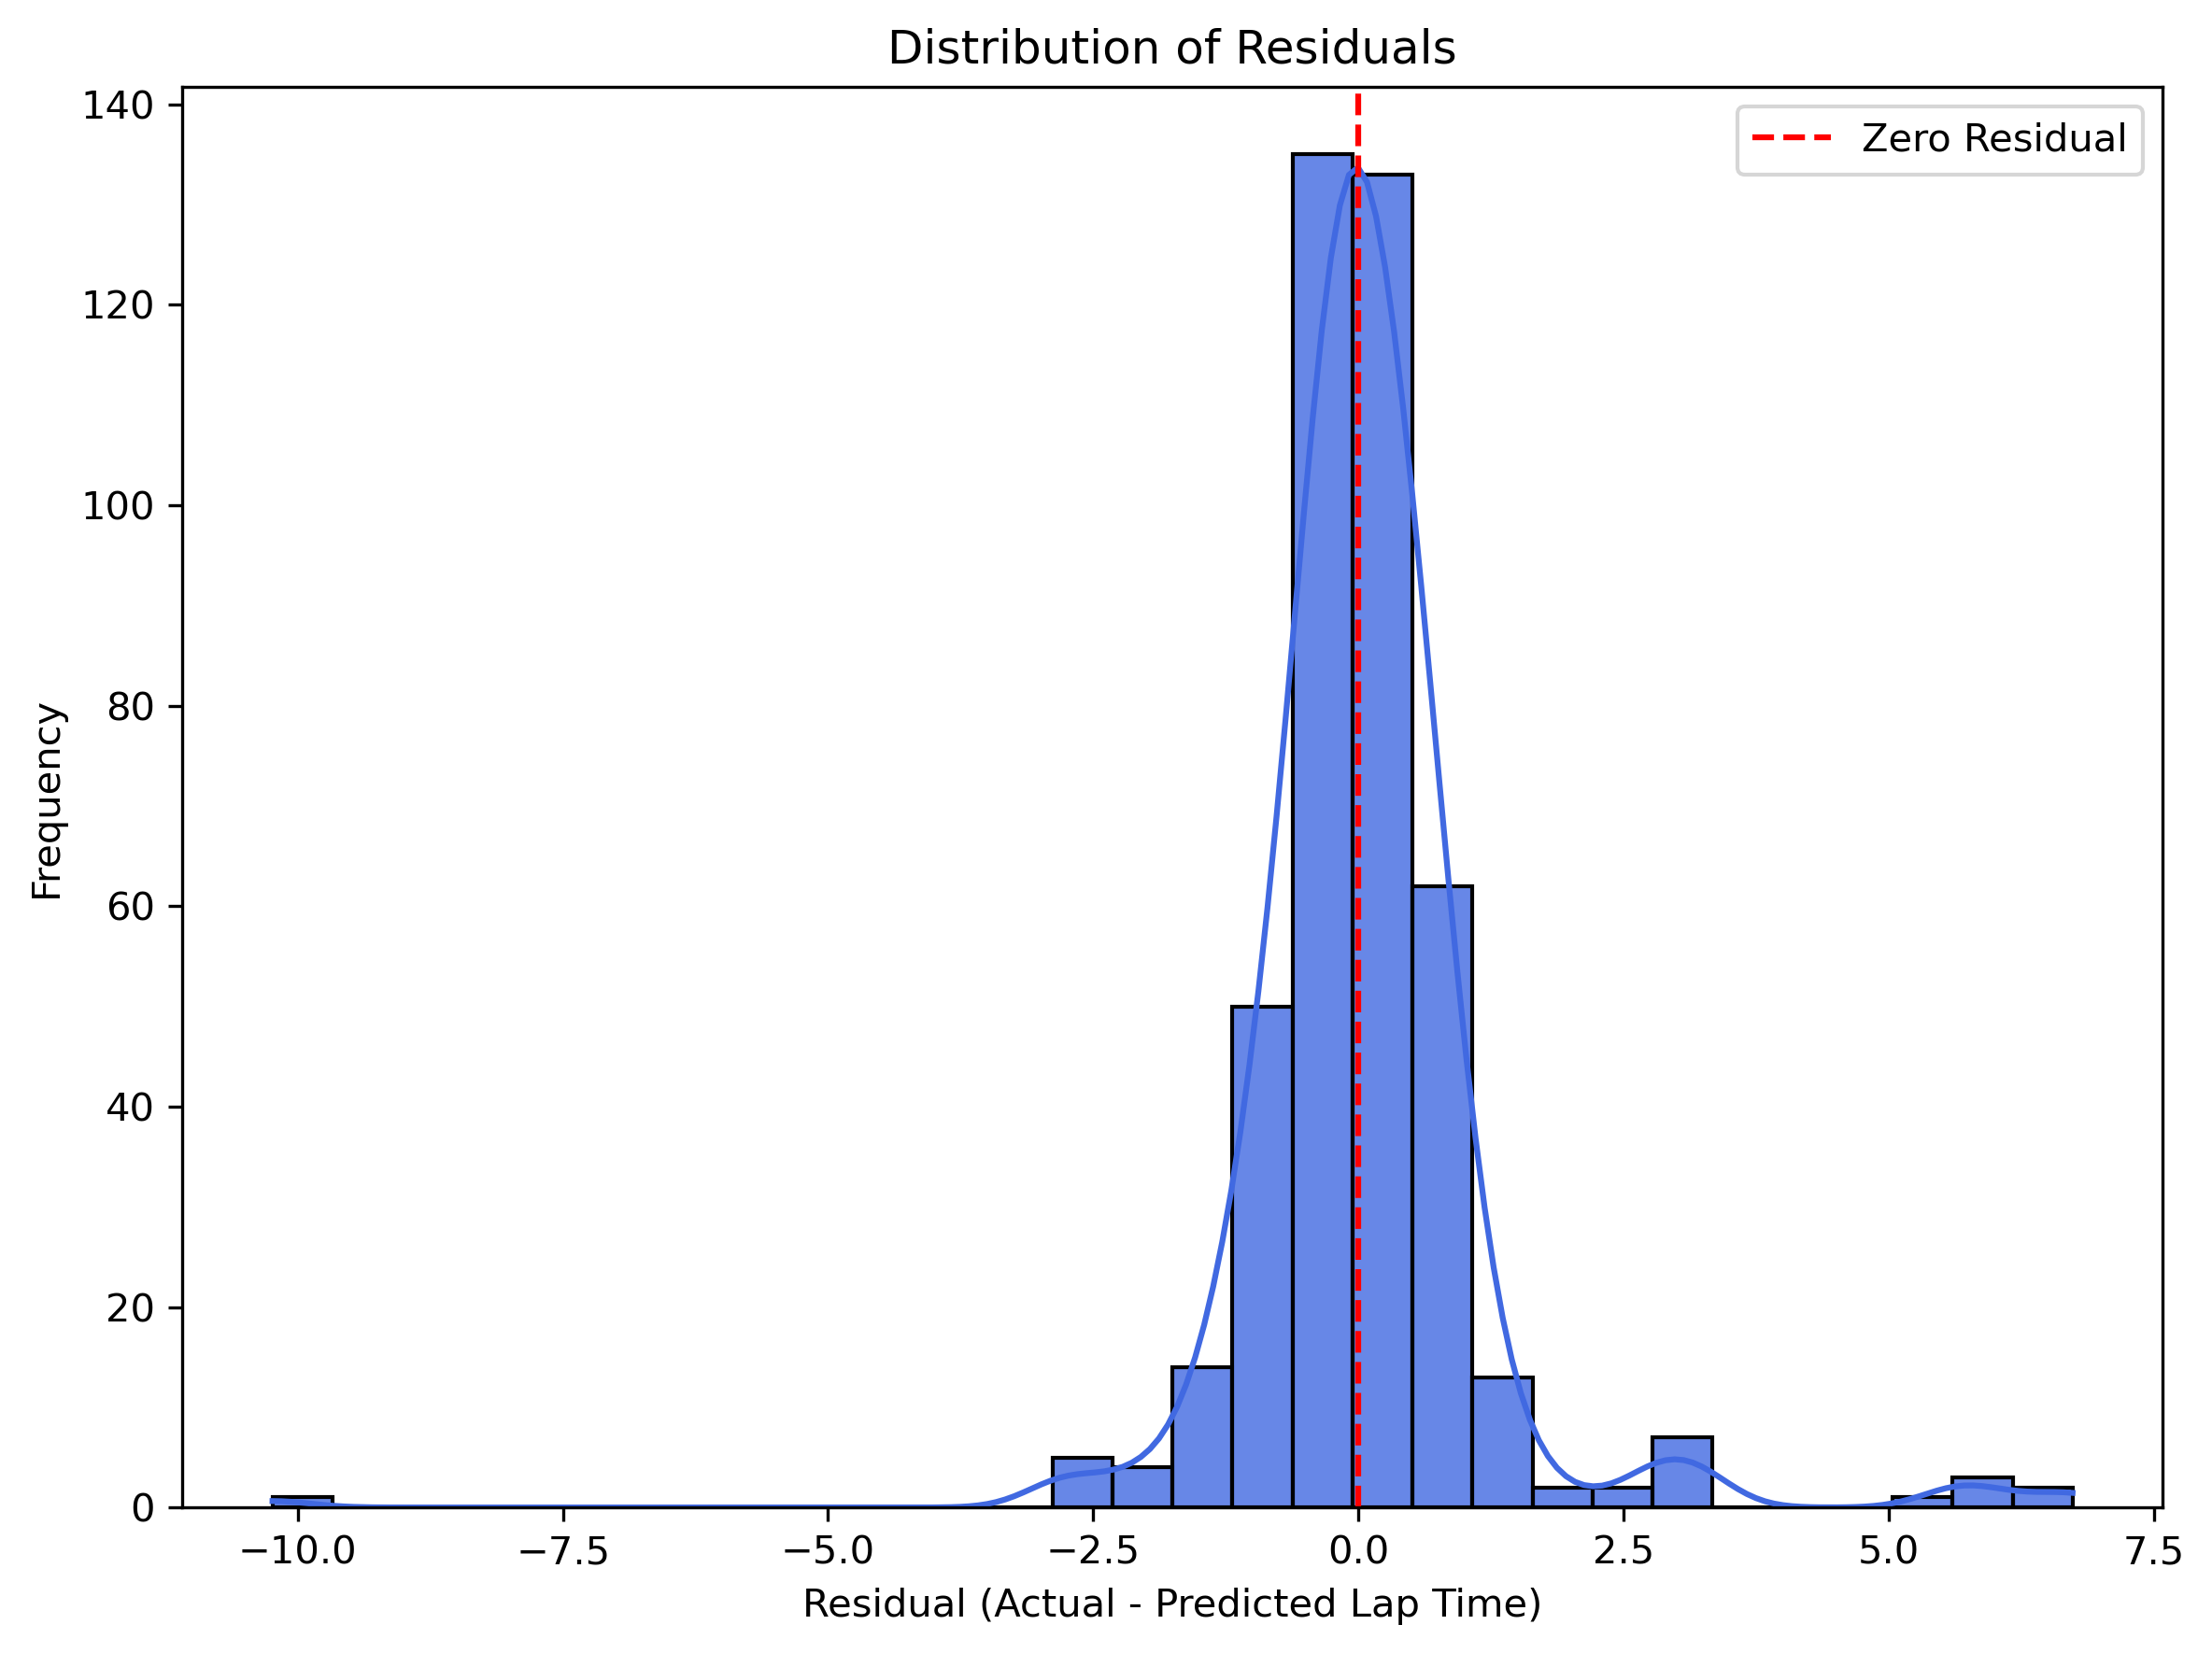

In [55]:
plt.figure(figsize=(8, 6), dpi=300)
sns.histplot(residuals, bins=30, kde=True, color='royalblue', alpha=0.8)
plt.axvline(0, color='red', linestyle='--', label="Zero Residual")
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted Lap Time)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
y_pred = best_estimator.predict(X_test)
X_test_with_meta = X_test.copy()
X_test_with_meta["ActualLapTime"] = y_test
X_test_with_meta["PredictedLapTime"] = y_pred

id_cols = ["Driver", "Team", "GrandPrix", "Year", "Round"]
merged = pd.merge(X_test_with_meta.reset_index(), df[id_cols], left_on="index", right_index=True)

In [57]:
race_df = merged[(merged["Year_x"] == 2023) & (merged["GrandPrix_x"] == "Miami Grand Prix")].copy()
race_df.sort_values("ActualLapTime", inplace=True)

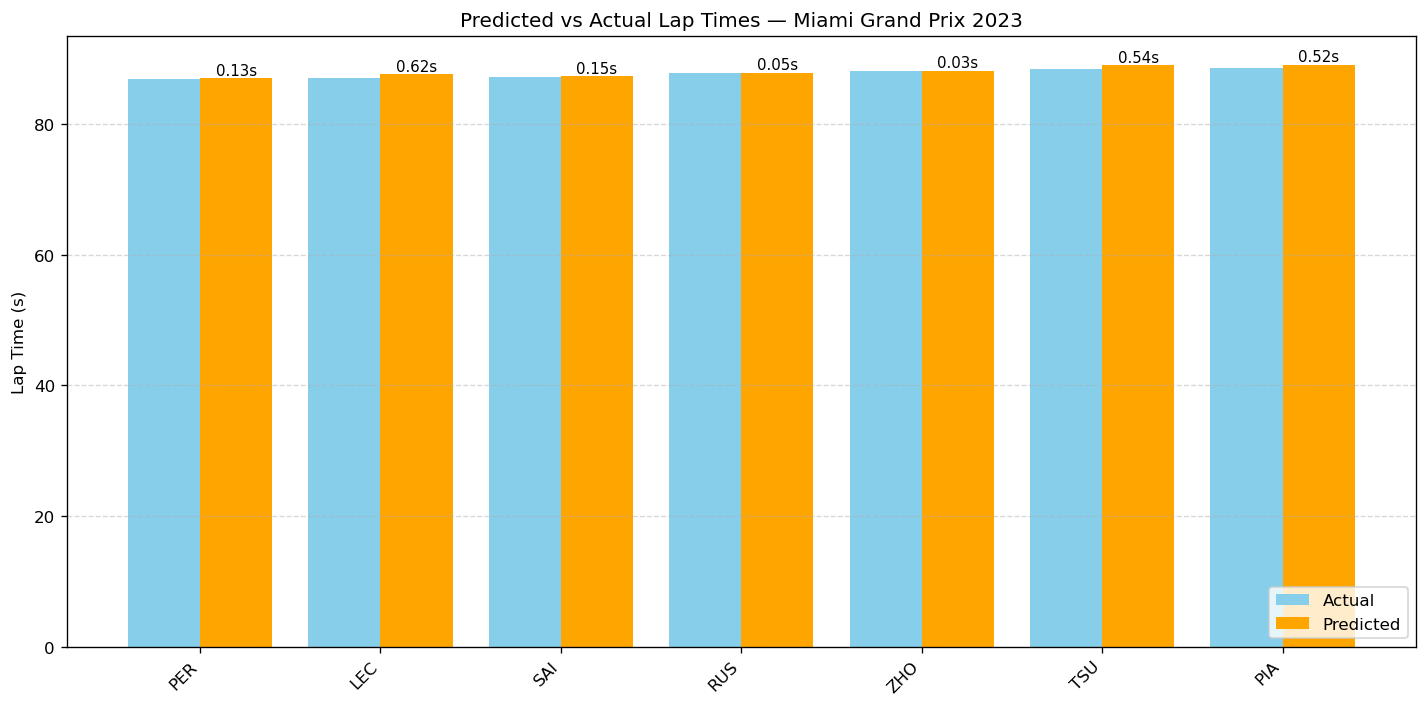

In [58]:
plt.figure(figsize=(12, 6), dpi=120)

bar_width = 0.4
indices = range(len(race_df))

# Residuals
residuals = race_df["PredictedLapTime"] - race_df["ActualLapTime"]

# Plot actual times
plt.bar(indices, race_df["ActualLapTime"], width=bar_width, label="Actual", color="skyblue")

# Plot predicted times next to actuals
plt.bar([i + bar_width for i in indices], race_df["PredictedLapTime"], width=bar_width, label="Predicted", color="orange")

# Driver labels
driver_labels = race_df["Driver_x"].values
plt.xticks([i + bar_width / 2 for i in indices], driver_labels, rotation=45, ha="right")

# Add error labels on predicted bars
for i, (x, res) in enumerate(zip(indices, residuals)):
    plt.text(x + bar_width, race_df["PredictedLapTime"].iloc[i] + 0.1,
             f"{res:.2f}s", ha='center', va='bottom', fontsize=9, color="black")

plt.ylabel("Lap Time (s)")
plt.title(f"Predicted vs Actual Lap Times — {race_df.iloc[0]['GrandPrix_x']} {race_df.iloc[0]['Year_x']}")
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [59]:
race_df = merged[(merged["Year_x"] == 2025) & (merged["GrandPrix_x"] == "Australian Grand Prix")].copy()
race_df.sort_values("ActualLapTime", inplace=True)

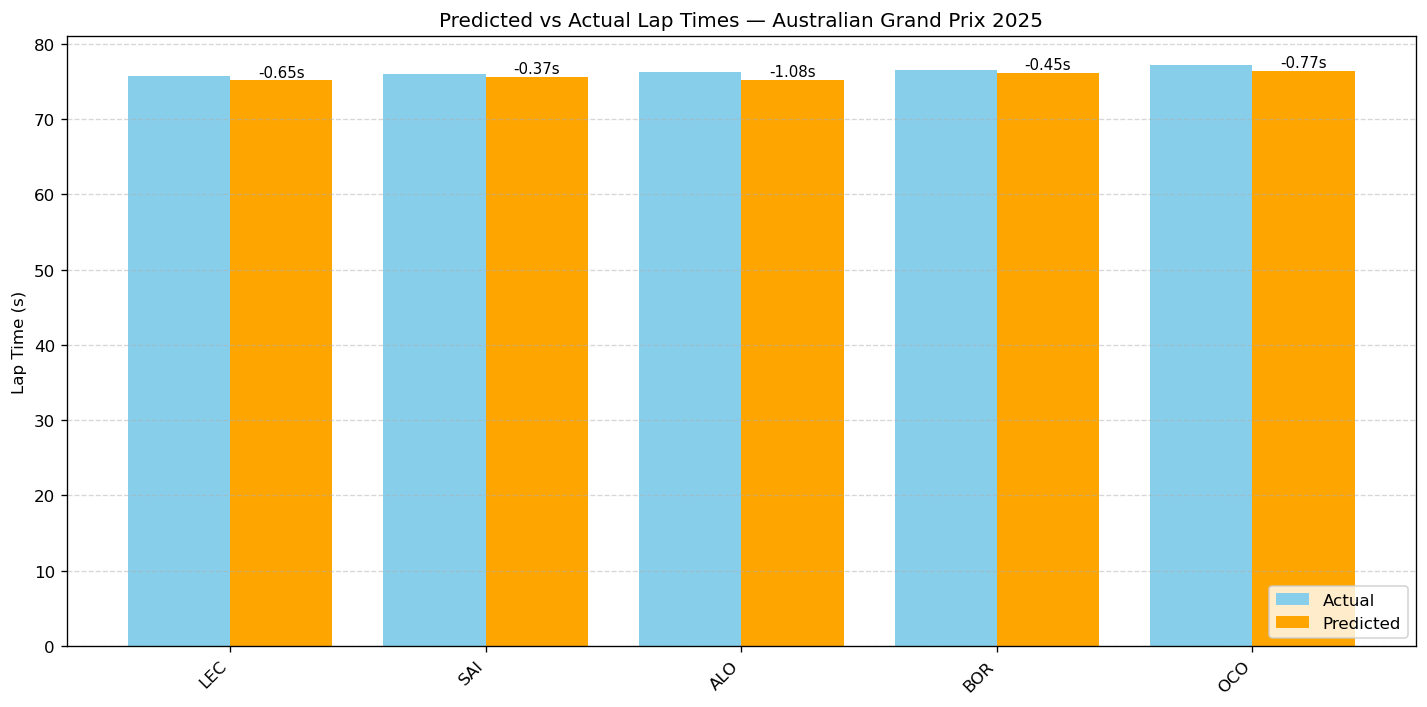

In [60]:
plt.figure(figsize=(12, 6), dpi=120)

bar_width = 0.4
indices = range(len(race_df))

# Residuals
residuals = race_df["PredictedLapTime"] - race_df["ActualLapTime"]

# Plot actual times
plt.bar(indices, race_df["ActualLapTime"], width=bar_width, label="Actual", color="skyblue")

# Plot predicted times next to actuals
plt.bar([i + bar_width for i in indices], race_df["PredictedLapTime"], width=bar_width, label="Predicted", color="orange")

# Driver labels
driver_labels = race_df["Driver_x"].values
plt.xticks([i + bar_width / 2 for i in indices], driver_labels, rotation=45, ha="right")

# Add error labels on predicted bars
for i, (x, res) in enumerate(zip(indices, residuals)):
    plt.text(x + bar_width, race_df["PredictedLapTime"].iloc[i] + 0.1,
             f"{res:.2f}s", ha='center', va='bottom', fontsize=9, color="black")

plt.ylabel("Lap Time (s)")
plt.title(f"Predicted vs Actual Lap Times — {race_df.iloc[0]['GrandPrix_x']} {race_df.iloc[0]['Year_x']}")
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [61]:
race_df = merged[(merged["Year_x"] == 2025) & (merged["GrandPrix_x"] == "Canadian Grand Prix")].copy()
race_df.sort_values("ActualLapTime", inplace=True)

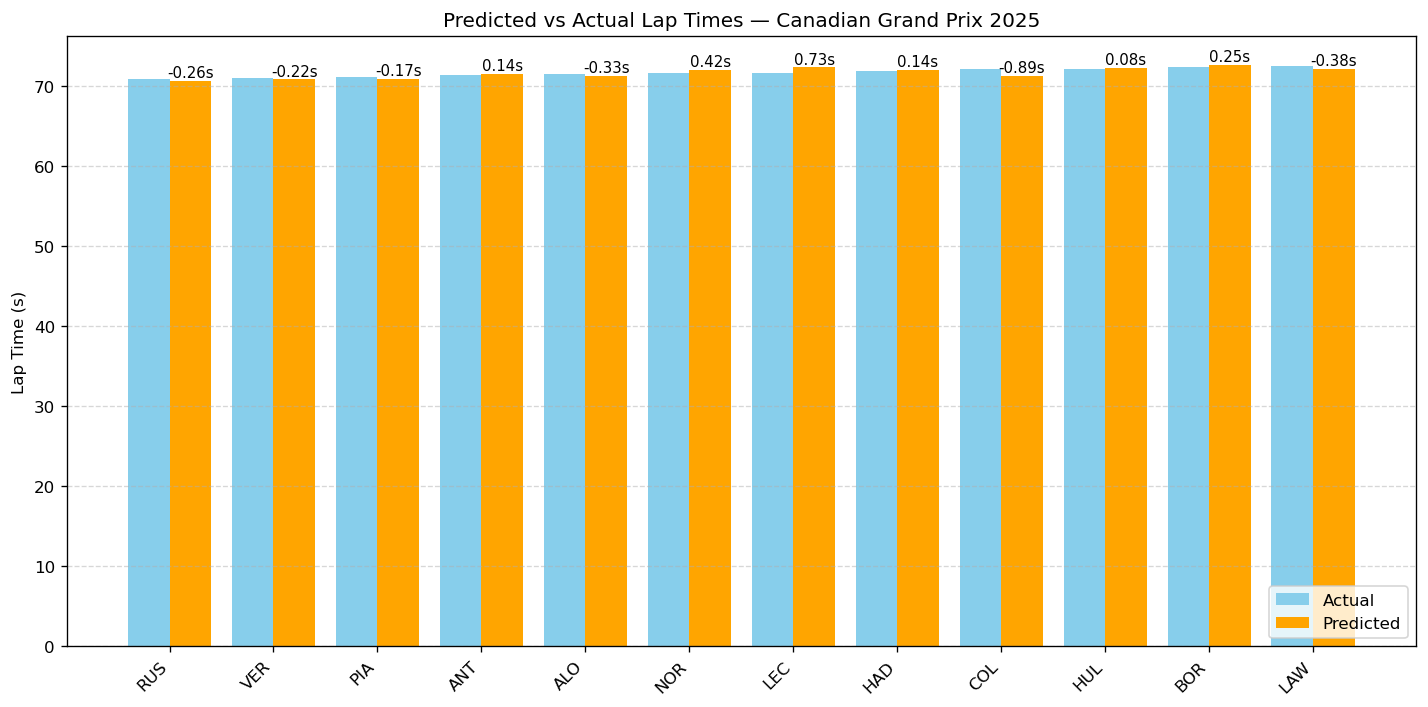

In [62]:
plt.figure(figsize=(12, 6), dpi=120)

bar_width = 0.4
indices = range(len(race_df))

# Residuals
residuals = race_df["PredictedLapTime"] - race_df["ActualLapTime"]

# Plot actual times
plt.bar(indices, race_df["ActualLapTime"], width=bar_width, label="Actual", color="skyblue")

# Plot predicted times next to actuals
plt.bar([i + bar_width for i in indices], race_df["PredictedLapTime"], width=bar_width, label="Predicted", color="orange")

# Driver labels
driver_labels = race_df["Driver_x"].values
plt.xticks([i + bar_width / 2 for i in indices], driver_labels, rotation=45, ha="right")

# Add error labels on predicted bars
for i, (x, res) in enumerate(zip(indices, residuals)):
    plt.text(x + bar_width, race_df["PredictedLapTime"].iloc[i] + 0.1,
             f"{res:.2f}s", ha='center', va='bottom', fontsize=9, color="black")

plt.ylabel("Lap Time (s)")
plt.title(f"Predicted vs Actual Lap Times — {race_df.iloc[0]['GrandPrix_x']} {race_df.iloc[0]['Year_x']}")
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()